# MSc Data Science project 2022-23

## Brain Tumor Segmentation using low computing resources

> By Rishikesh Pandey

> 2820887P



## Sumary
We will use MICCAI's Brain tumor segmentation dataset for this project, this data was provided by Synapse.org for FeTS challenge. The goal here is to prepare a model that can train and predict brain tumors on low computing resources. The dataset had around 8000 scans with each subject containing 4 scans and a mask. We will first preprocess our data to simply input and reduce computation.

---
We will be using pytorch for our model implementation which will be a 3D Unet model made from scratch using pytorch's neural network library. This model needs to be efficient enough to run in google colab where it was created and tested.


# Code Details

## Global defaults and imports
This block of code contains all the necessary setup, imports and global variables that are needed for the entire code to run smoothly. We will be using a google drive account that contains the MICCAI dataset. Few libraries that aren't default to google colab are also installed below.<br>
Note : The block below should be commented, if this script is running on a local machine

In [ ]:
# Setting up google drive connection
# Comment this if running on a local setup
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
# Necessary installations
!python --version
!pip --quiet install patchify

Python 3.10.12


In [ ]:
# All required imports for the entire code
from ipywidgets import interact, interactive, IntSlider, ToggleButtons
from tensorflow.keras.utils import to_categorical
from torch.utils.data import DataLoader, Dataset
from patchify import patchify, unpatchify
import matplotlib.pyplot as plt, random
from collections import defaultdict
from torchsummary import summary
import torch.nn.functional as F
from tqdm.notebook import tqdm
from torch import nn, optim
from os.path import join
import tensorflow as tf
import nibabel as nib
from torch import nn
from os import path
import numpy as np
import torch
import math
import glob
import os

In [ ]:
# GLOBAL variables
epochs = 10
pin_memory = False
total_train_subjects = 10
total_test_subjects = 5
test_batch_size = 5

# Create input and output storage if does not exist, change location according to environment
if path.exists('/content/inputs') == False:
  os.mkdir('/content/inputs')

if path.exists('/content/masks') == False:
  os.mkdir('/content/masks')

# root_dir,input_save and mask_save should be changed according to users environment
root_dir = "drive/MyDrive/"
MICCAI_fldr = "MICCAI_FeTS2022_TrainingData"
input_save = '/content/inputs'
mask_save = '/content/masks'

fldr = join(root_dir, MICCAI_fldr)
os.path.isdir(fldr)

# use pin_memory only if GPU is available
device = torch.device("cpu")
if(torch.cuda.is_available()):
    device = torch.device("cuda")
    pin_memory = True

# Data Preprocessing

This block handles fetching data and storing it as a dataset for our pytorch model to use. The Scans are of .NiFTI extension often used for MRI images. We will convert them into a numpy array which will be initially of size 155 x 240 x 240. Since each single scan will be of that many dimensions and each subject has 5 scans, even a few subjects would increase the load on RAM significantly. We will break it down into "patches" or "slices" so each so only a portion of a scan will be considered as an input image for the model. The size of these patches would be 64 x 64 x 64

In [ ]:
# Approach 1: Using RAM space to store input files, Approach 2: Using secondary disk
# Comment the below lines to save input and mask images for the dataset on disk, Approach 2 in report.
# This would reduce RAM usage and save files to disk.

files_inp = glob.glob(input_save+"/*.npy")
print("No. of files to delete: ",len(files_inp))
files_mask = glob.glob(mask_save+"/*.npy")
for f in files_inp:
    os.remove(f)
for f in files_mask:
    os.remove(f)
files_inp = glob.glob(input_save+"/*.npy")
print("No. of files left",files_inp)

No. of files to delete:  0
No. of files left []


In [ ]:
# This class is used to modify all aspects of the input and work as a dataset for pytorch.
# Pytorch will automatically use this class to obtain data from.
# Inside __init__ we run through all images to only use images that are not blank
# We pick subjects randomly of the given subject size (total_subjects)

class NiftiDataset(Dataset):
    def __init__(self, root_dir,total_subjects = total_train_subjects, isVal = False):
        self.root_dir = root_dir
        self.folder_list = [folder for folder in random.sample(os.listdir(root_dir),total_subjects) if os.path.isdir(os.path.join(root_dir, folder))]
        self.total_data = 0
        self.isVal = isVal

        self.all_images, self.all_masks = [],[]

        self.visual_mask = 0

        print("Please wait, 5 x total_data images are being broken down into slices of 64 x 64 x 64 each\nwhile also filtering out slices which do not have mask data or a useful label")

        for folder in self.folder_list:
            folder_path = os.path.join(self.root_dir, folder)

            t1 = glob.glob(folder_path+'/*t1.nii.gz')
            t1ce = glob.glob(folder_path+'/*t1ce.nii.gz')
            t2 = glob.glob(folder_path+'/*t2.nii.gz')
            flair = glob.glob(folder_path+'/*flair.nii.gz')
            seg = glob.glob(folder_path+'/*seg.nii.gz')

            # Use patch_images function to crop out images and turn them into slices
            if len(flair)>0:
                flair = self.patch_images(flair[0])

            if len(t1)>0:
                t1 = self.patch_images(t1[0])

            if len(t1ce)>0:
                t1ce = self.patch_images(t1ce[0])

            if len(t2)>0:
                t2 = self.patch_images(t2[0])

            if len(seg)>0:
                seg = self.patch_images(seg[0])

                # If a mask is available, we consider the image as input

                # We take a slice from all scans and stack them together for our input(except mask)

                # Change the value of 4th label to 3, The dataset did not give any label for 3
                seg[seg == 4] = 3

                # For validation we can use the entire image and not slices
                if(self.isVal):
                    self.total_data = len(self.folder_list)
                    x = np.stack([t1, t1ce, t2, flair], axis=-1).astype(np.float32)
                    self.all_images.append(x)

                    y = seg.astype(np.float32)
                    y = (self.to_categorical(y, 4)).astype(np.float32)
                    self.all_masks.append(y)

                    continue

                for i in range(seg.shape[0]):
                    val, counts = np.unique(seg[i], return_counts=True)
                    if (1 - (counts[0]/counts.sum())) > 0.01:

                        x = np.stack([t1[i], t1ce[i], t2[i], flair[i]], axis=-1).astype(np.float32)
                        # self.all_images.append(x)
                        np.save(input_save+"/"+str(self.total_data),x)

                        # Comment np.save line
                        # and Uncomment self.all_images line for both x and y for approach 1

                        y = seg[i].astype(np.float32)

                        if(self.total_data==0):
                            self.visual_mask = y
                            print(self.visual_mask.shape)

                        y = (self.to_categorical(y, 4)).astype(np.float32)
                        # self.all_masks.append(y)
                        np.save(mask_save+"/"+str(self.total_data),y)


                        self.total_data += 1

    def get_total(self):
        return self.total_data

    def __len__(self):
        return self.total_data

    # Take first image to display its single slice of all 5 scans
    def visualize(self, ix):
        x,y = self.__getitem__(ix)
        y = self.visual_mask
        combined_x = x
        n_slice = random.randint(0, x.shape[2] - 1)
        plt.figure(figsize=(12, 8))
        plt.subplot(231)
        plt.imshow(combined_x[:, :, n_slice, 0], cmap="gray")
        plt.title('T1 Scan')

        plt.subplot(232)
        plt.imshow(combined_x[:, :, n_slice, 1], cmap="gray")
        plt.title('T1ce Scan')

        plt.subplot(233)
        plt.imshow(combined_x[:, :, n_slice, 2], cmap="gray")
        plt.title('T2 Scan')

        plt.subplot(234)
        plt.imshow(combined_x[:, :, n_slice, 3], cmap="gray")
        plt.title('Flair Scan')

        plt.subplot(235)
        plt.imshow(y[:, :, n_slice])
        plt.title('Mask')

    # Convert mask array into classes
    def to_categorical(self, y, num_classes):
        """ 1-hot encodes a tensor """
        y = to_categorical(y, num_classes)
        return y

    def patch_images(self,image):

        # Fetching, cropping and reshaping a single image
        image = nib.load(image).get_fdata()
        image = image[56:184, 56:184, 13:141]# Perform center crop with dimensions 128 x 128 x 128
        if(self.isVal):
            return image
        image = patchify(image,(64,64,64),step=32)
        image = np.reshape(image,(-1,image.shape[3],image.shape[4],image.shape[5]))
        return image

    # This method is used by pytorch to fetch one batch size data at a time
    def __getitem__(self, idx):

        # Uncomment for running approach 1
        # return torch.from_numpy(self.all_images[idx]), torch.from_numpy(self.all_masks[idx]), 0

        # Below code for Approach 2

        if(self.isVal):
            return torch.from_numpy(self.all_images[idx]), torch.from_numpy(self.all_masks[idx]), 0

        x = np.load(input_save+"/"+str(idx)+".npy")
        y = np.load(mask_save+"/"+str(idx)+".npy")

        return torch.from_numpy(x), torch.from_numpy(y)


In [ ]:
# Create dataset object for training and testing
# If isVal is set to True it will use 128 x 128 x 128 images and not patchify them
dat = NiftiDataset(fldr,total_train_subjects,False)
val_dat = NiftiDataset(fldr,total_test_subjects,False)

Please wait, 5 x total_data images are being broken down into slices of 64 x 64 x 64 each
while also filtering out slices which do not have mask data or a useful label
(64, 64, 64)
Please wait, 5 x total_data images are being broken down into slices of 64 x 64 x 64 each
while also filtering out slices which do not have mask data or a useful label
(64, 64, 64)


In [ ]:
total_train_data = dat.get_total()
total_test_data = val_dat.get_total()
batch_size = total_train_data//epochs
train_data, test_data = dat, val_dat

print("Training batch size:",batch_size)
print("Validation batch size",test_batch_size)

Training batch size: 13
Validation batch size 5


In [ ]:
print("Length of training images:",len(dat))
print("Length of testing images:",len(val_dat))

Length of training images: 136
Length of testing images: 50


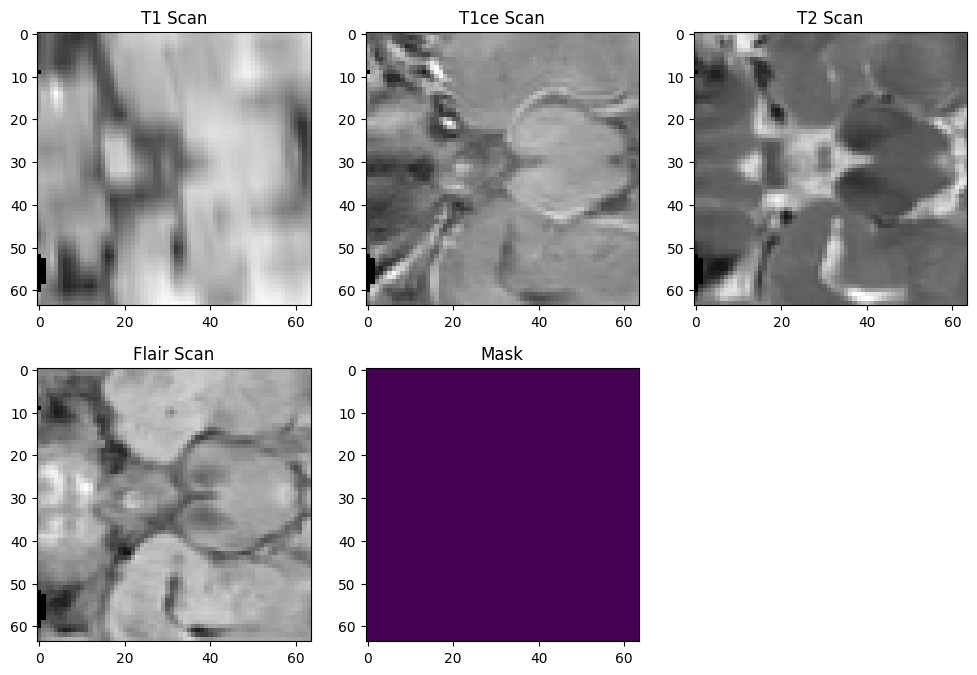

In [ ]:
# Single slice displayed for understanding the input data, mask is printed in colour to distinguish labels
# Some random slices dont show mask as they could be the end regions of the scan
dat.visualize(0)

In [ ]:
# Create training and validation data loader for PyTorch
train_dataloader = DataLoader(train_data,
                              batch_size = batch_size,
                              num_workers= 0,
                              pin_memory=pin_memory,
                              shuffle=True)

val_dataloader = DataLoader(test_data, batch_size = test_batch_size, num_workers=0, pin_memory=pin_memory, shuffle=False)

In [ ]:
# Variable to check shape of training input
x, y = train_data.__getitem__(0)
print(x.shape,y.shape)

torch.Size([64, 64, 64, 4]) torch.Size([64, 64, 64, 4])


In [ ]:
# Variable to check shape of validation input
x_val,y_val = test_data[0]
print(x_val.shape,y_val.shape)

torch.Size([64, 64, 64, 4]) torch.Size([64, 64, 64, 4])


In [ ]:
# One single batch
ex,ey = next(iter(train_dataloader))
print(ex.shape)
print(ey.shape)

torch.Size([13, 64, 64, 64, 4])
torch.Size([13, 64, 64, 64, 4])


# Training Data
This block creates a 3D Unet model using PyTorch and uses custom focal loss and dice score as loss and accuracy metric. The Unet Model is divided into 8 layers (4 encoder x 4 decoder) and uses 3D convolutional network along with ReLU, max pooling and batch normalization.

In [ ]:
class ConvUnit(nn.Module):
    """
        Convolution Unit: (Conv3D -> BatchNorm -> ReLu) * 2
    """
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size = 3, padding = 1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True), # inplace=True means it changes the input directly, input is lost

            nn.Conv3d(out_channels, out_channels, kernel_size = 3, padding = 1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True))

    def forward(self,x):
        return self.double_conv(x)

class EncoderUnit(nn.Module):
    """
    An Encoder Unit with the ConvUnit and MaxPool
    """
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.MaxPool3d(2),
            ConvUnit(in_channels, out_channels)
        )
    def forward(self, x):
        return self.encoder(x)

class DecoderUnit(nn.Module):
    """
    ConvUnit and upsample with Upsample or convTranspose
    """
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose3d(in_channels // 2, in_channels // 2, kernel_size=2, stride=2)
        self.conv = ConvUnit(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)

        diffZ = x2.size()[2] - x1.size()[2]
        diffY = x2.size()[3] - x1.size()[3]
        diffX = x2.size()[4] - x1.size()[4]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2, diffZ // 2, diffZ - diffZ // 2])

        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv3d(in_channels, out_channels, kernel_size = 1)

    def forward(self, x):
        return self.conv(x)

class UNet3d(nn.Module):
    def __init__(self, in_channels, n_classes, s_channels):
        super().__init__()

        # Initializing all the layers created above in their particular format to create a 3D Unet
        self.in_channels = in_channels
        self.n_classes = n_classes
        self.s_channels = s_channels

        # Encoding layers
        self.conv = ConvUnit(in_channels, s_channels)
        self.enc1 = EncoderUnit(s_channels, 2 * s_channels)
        self.enc2 = EncoderUnit(2 * s_channels, 4 * s_channels)
        self.enc3 = EncoderUnit(4 * s_channels, 8 * s_channels)
        self.enc4 = EncoderUnit(8 * s_channels, 8 * s_channels)

        # Decoding layers
        self.dec1 = DecoderUnit(16 * s_channels, 4 * s_channels)
        self.dec2 = DecoderUnit(8 * s_channels, 2 * s_channels)
        self.dec3 = DecoderUnit(4 * s_channels, s_channels)
        self.dec4 = DecoderUnit(2 * s_channels, s_channels)
        self.out = OutConv(s_channels, n_classes)

    def forward(self, x):
        # Feed Forward layer with inputs
        x = x.permute(0, 4, 1, 2, 3)
        x1 = self.conv(x)
        x2 = self.enc1(x1)
        x3 = self.enc2(x2)
        x4 = self.enc3(x3)
        x5 = self.enc4(x4)

        mask = self.dec1(x5, x4)
        mask = self.dec2(mask, x3)
        mask = self.dec3(mask, x2)
        mask = self.dec4(mask, x1)
        mask = self.out(mask)
        return mask, x5

In [ ]:
class FocalLoss(nn.Module):
    # Focal loss (instead of cross entropy) using BCEloss for calculating loss
    def __init__(self, alpha=1, gamma=2, logits=True, reduce=True):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduce = reduce
        self.loss_fn = (nn.BCEWithLogitsLoss if logits else nn.BCELoss)(reduction = 'none')

    def forward(self, pred, target):
        target = target.permute(0, 4, 1, 2, 3)
        BCE_loss = self.loss_fn(pred, target)
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss
        return F_loss.mean() if self.reduce else F_loss

In [ ]:
class DiceScore(nn.Module):
    # Dice score to get the accuracy of the model
    def __init__(self, smooth=1e-6):
        super().__init__()
        self.smooth = smooth

    def forward(self, pred, target):
        pred = torch.sigmoid(pred)
        batch_size = target.size(0)
        pred = pred.reshape(batch_size, -1)
        target = target.reshape(batch_size, -1)
        intersection = (pred * target).sum()
        score = (2. * intersection + self.smooth) / (pred.sum() + target.sum() + self.smooth)
        return score


In [ ]:
# Define the parameters

in_channels = 4  # Since the input data has 4 channels(scan types)
n_classes = 4    # Number of labels we want to predict
s_channels = 16  # Initial number of channels for the convolutional layers

# Instantiate the model
model = UNet3d(in_channels, n_classes, s_channels)

In [ ]:
# Get Summary of model
model.to(device)
summary(model,x.shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1       [-1, 16, 64, 64, 64]           1,744
       BatchNorm3d-2       [-1, 16, 64, 64, 64]              32
              ReLU-3       [-1, 16, 64, 64, 64]               0
            Conv3d-4       [-1, 16, 64, 64, 64]           6,928
       BatchNorm3d-5       [-1, 16, 64, 64, 64]              32
              ReLU-6       [-1, 16, 64, 64, 64]               0
          ConvUnit-7       [-1, 16, 64, 64, 64]               0
         MaxPool3d-8       [-1, 16, 32, 32, 32]               0
            Conv3d-9       [-1, 32, 32, 32, 32]          13,856
      BatchNorm3d-10       [-1, 32, 32, 32, 32]              64
             ReLU-11       [-1, 32, 32, 32, 32]               0
           Conv3d-12       [-1, 32, 32, 32, 32]          27,680
      BatchNorm3d-13       [-1, 32, 32, 32, 32]              64
             ReLU-14       [-1, 32, 32,

In [ ]:
#Save and load model
def save_ckp(state, is_best, checkpoint_path):
    """
    state: checkpoint we want to save
    is_best: is this the best checkpoint; min validation loss
    checkpoint_path: path to save checkpoint
    best_model_path: path to save best model
    """
    # save checkpoint data to the path given, checkpoint_path
    f_path = checkpoint_path

    # if best model, min validation loss
    if is_best:
      torch.save(state, f_path)



def load_ckp(checkpoint_fpath, model, optimizer):
    """
    checkpoint_path: path to save checkpoint
    model: model that we want to load checkpoint parameters into
    optimizer: optimizer we defined in previous training
    """
    # load check point
    checkpoint = torch.load(checkpoint_fpath)

    # initialize state_dict from checkpoint to model
    model.load_state_dict(checkpoint['state_dict'])

    # initialize optimizer from checkpoint to optimizer
    optimizer.load_state_dict(checkpoint['optimizer'])

    # return model, optimizer, epoch value, min validation loss
    return model, optimizer, checkpoint['epoch']

In [ ]:
def train_model(starting_epoch, num_epochs, model, train_dataloader, val_dataloader, save_checkpoint, path, training_losses: list = [], valid_losses: list = []):
    #
    for epoch in range(starting_epoch, num_epochs):
        # inner variables
        tloss = 0
        vloss = 0
        total_score = 0
        total = 0

        with tqdm(train_dataloader, unit= 'batch') as train_loader:

            model.train(True) #set the model to training mode

            for i, (inputs, labels) in enumerate(train_loader):

                # clear the gradients of all optimized variables
                optimizer.zero_grad(set_to_none=True)

                inputs = inputs.to(device, non_blocking=True)
                labels = labels.to(device, non_blocking=True)
                image = inputs.float()
                labels = labels.float()

                # forward pass: compute predicted outputs by passing inputs to the model
                prediction,_ = model(image)

                # calculate the batch loss
                loss = criterion(prediction,labels)

                # backward pass: compute gradient of the loss with respect to model parameters
                loss.backward()

                # perform a single optimization step (parameter update)
                optimizer.step()

                #log training loss
                tloss += loss.item()

                train_loader.set_postfix(stats='Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, tloss/len(train_dataloader)))

        # Epoch loss for all training iteration of a single epoch
        epoch_loss = tloss/len(train_dataloader)
        training_losses.append(epoch_loss)
        torch.cuda.empty_cache()


        # validate the model
        with tqdm(val_dataloader, unit="batch") as valid_loader:

            model.train(False)

            for i, (inputs, labels) in enumerate(valid_loader):

                with torch.no_grad():

                    inputs = inputs.to(device, non_blocking=True)
                    labels = labels.to(device, non_blocking=True)
                    image = inputs.float()
                    labels= labels.float()
                    prediction,_ = model(image)

                    # calculate the batch loss
                    loss = criterion(prediction,labels)
                    vloss += loss.item()
                    total += labels.size(0)

                    # get accuraccy
                    score = metric(prediction, labels)
                    total_score += score

                valid_loader.set_postfix(stats='Epoch: {} \tValid Loss: {:.6f}\tScore is: {:.4f}'.format(epoch, vloss/len(val_dataloader), score))

        # Epoch loss for all validation iteration of a single epoch
        valid_epoch_loss = vloss/len(val_dataloader)
        valid_losses.append(valid_epoch_loss)

        # Save model checkpoint after each epoch
        if save_checkpoint:
            checkpoint = {
            'epoch': epoch+1,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            }
            save_ckp(checkpoint, True, os.path.join(path, '{}-{}.pth'.format('unet3D', epoch)))
        torch.cuda.empty_cache()

In [ ]:
# Create location to save models
model_dir = 'test-models'

if not os.path.isdir(model_dir):
    os.makedirs(model_dir)

assert os.path.isdir(model_dir), f"{model_dir} does not exist"

In [ ]:
if __name__ == '__main__':
  print("Running on", device)

  # model and criterion
  training_losses =[]
  valid_losses=[]

  # Metric
  metric = DiceScore()

  #loss function
  criterion = FocalLoss()

  #Assess model type
  optimizer = optim.Adam(model.parameters(), lr=0.0001)
  model = model.to(device)

  # Train
  train_model(0, epochs, model, train_dataloader, val_dataloader, True, model_dir, training_losses, valid_losses)

Running on cuda


  0%|          | 0/11 [00:00<?, ?batch/s]

  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/11 [00:00<?, ?batch/s]

  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/11 [00:00<?, ?batch/s]

  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/11 [00:00<?, ?batch/s]

  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/11 [00:00<?, ?batch/s]

  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/11 [00:00<?, ?batch/s]

  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/11 [00:00<?, ?batch/s]

  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/11 [00:00<?, ?batch/s]

  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/11 [00:00<?, ?batch/s]

  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/11 [00:00<?, ?batch/s]

  0%|          | 0/10 [00:00<?, ?batch/s]

[0.20987884293903003, 0.19389692626216196, 0.18500978431918405, 0.177650662985715, 0.16964037309993396, 0.16207858242771842, 0.15601870959455316, 0.14904167028990659, 0.14290541952306574, 0.13790347494862296]
[0.1932825967669487, 0.19451283067464828, 0.19149572849273683, 0.17976988703012467, 0.16502610892057418, 0.1581625074148178, 0.15842696875333787, 0.1445459932088852, 0.13905029296875, 0.13625105693936349]


<function matplotlib.pyplot.show(close=None, block=None)>

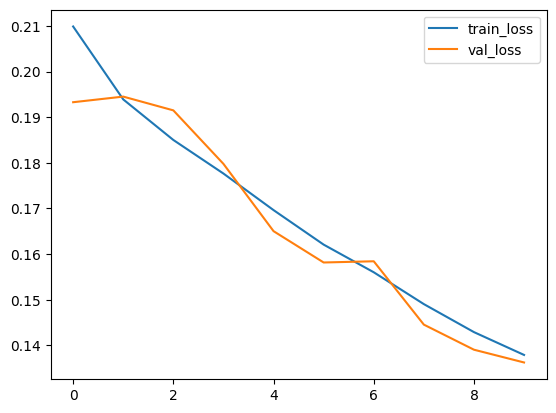

In [ ]:
# Gathering and displaying loss values
print(training_losses)
print(valid_losses)

# Plotting
plt.plot(training_losses, label='train_loss')
plt.plot(valid_losses,label='val_loss')
plt.legend()
plt.show

# Visualization and testing

In [ ]:
# A subject folder location entered manually, any subject can be put here at random to test the model
subject_loc = '/content/drive/MyDrive/MICCAI_FeTS2022_TrainingData/FeTS2022_00000/FeTS2022_00000_'
inp1 = nib.load(subject_loc+'t1.nii.gz').get_fdata()[56:184, 56:184, 13:141]
inp2 = nib.load(subject_loc+'t2.nii.gz').get_fdata()[56:184, 56:184, 13:141]
inp3 = nib.load(subject_loc+'flair.nii.gz').get_fdata()[56:184, 56:184, 13:141]
inp4 = nib.load(subject_loc+'t1ce.nii.gz').get_fdata()[56:184, 56:184, 13:141]
mask = nib.load(subject_loc+'seg.nii.gz').get_fdata()[56:184, 56:184, 13:141]

# Running data through model
inp = np.expand_dims(np.stack([inp1,inp2,inp3,inp4]),axis=0)
inp = inp.swapaxes(1,4)
inp = (torch.from_numpy(inp)).to(device, non_blocking=True)

model = model.to(device)
output,_ = model(inp.float())

print("Input shape: ",inp.shape)
print("Output shape: ",output.shape)

Input shape:  torch.Size([1, 128, 128, 128, 4])
Output shape:  torch.Size([1, 4, 128, 128, 128])


In [ ]:
# Detaching images from model
op = output.detach().cpu().numpy()
ip = inp.detach().cpu().numpy()

# Printing details
op = op.swapaxes(1,4)
print(op.shape)
print(ip.shape)

(1, 128, 128, 128, 4)
(1, 128, 128, 128, 4)


In [ ]:
# Plotting 3D slider visualisation of Training and predicted image
# Use the slider to change images
default = True
channel = 3

def Vis3d(layer):

    if default : fig = op[0,:,:,:,:]
    else : fig = ip[0, :, :, :, :]

    plt.figure(figsize=(8,6))
    plt.imshow(fig[layer, :, :, channel])
    plt.axis('off')
    plt.show()
    return layer

interact(Vis3d, layer=(0, op.shape[2]-1))
default = False
interact(Vis3d, layer=(0, ip.shape[2]-1))

interactive(children=(IntSlider(value=63, description='layer', max=127), Output()), _dom_classes=('widget-inte…

interactive(children=(IntSlider(value=63, description='layer', max=127), Output()), _dom_classes=('widget-inte…

<function __main__.Vis3d(layer)>

In [ ]:
# Mask 3D slider visualization, done seperately for ease of comparison without scolling

def Vis3dMask(layer):

    plt.figure(figsize=(8,6))
    plt.imshow(mask[layer, :, :])
    plt.axis('off')
    plt.show()
    return layer

interact(Vis3dMask, layer=(0, mask.shape[2]-1))

interactive(children=(IntSlider(value=63, description='layer', max=127), Output()), _dom_classes=('widget-inte…

<function __main__.Vis3dMask(layer)>

#References :

[1] S.Pati, U.Baid, M.Zenk, B.Edwards, M.Sheller, G.A.Reina, et al., "The Federated Tumor Segmentation (FeTS) Challenge", arXiv preprint arXiv:2105.05874 (2021).

[2] G.A.Reina, A.Gruzdev, P.Foley, O.Perepelkina, M.Sharma, I.Davidyuk, et al., “OpenFL: An open-source framework for Federated Learning”, arXiv preprint arXiv: 2105.06413 (2021)

[3] U.Baid, S.Ghodasara, S.Mohan, M.Bilello, E.Calabrese, E.Colak, et.al., "The RSNA-ASNR-MICCAI Brats 2021 Benchmark on Brain Tumor Segmentation and Radiogenomic Classification", arXiv preprint arXiv: 2107.02314 (2021)

[4] A. Karargyris, R. Umeton, M.J. Sheller, A. Aristizabal, J. George, A. Wuest, S. Pati, et al. "Federated benchmarking of medical artificial intelligence with MedPerf". Nature Machine Intelligence. 5:799–810 (2023). DOI: https://doi.org/10.1038/s42256-023-00652-2

Additionally, the manuscript below contains the results of a simulated study directly related to the FeTS challenge.

[5] M.J.Sheller, B.Edwards, G.A.Reina, J.Martin, S.Pati, A.Kotrotsou, et al., "Federated learning in medicine: facilitating multi-institutional collaborations without sharing patient data", Nature Scientific Reports, 10:12598 (2020) DOI: 10.1038/s41598-020-69250-1